In [ ]:
import json
import numpy as np
import pandas as pd
from torch_geometric_temporal.signal.dynamic_graph_temporal_signal import DynamicGraphTemporalSignal

In [ ]:
def transform_degree(x, cutoff=4):
    log_deg = np.ceil(np.log(x + 1.0))
    return np.minimum(log_deg, cutoff)


def transform_transitivity(x):
    trans = x * 10
    return np.floor(trans)


def onehot_encoding(x, unique_vals):
    E = np.zeros((len(x), len(unique_vals)))
    for i, val in enumerate(x):
        E[i, unique_vals.index(val)] = 1.0
    return E


def encode_features(X, log_degree_cutoff=4):
    X_arr = np.array(X)
    a = transform_degree(X_arr[:, 0], log_degree_cutoff)
    b = transform_transitivity(X_arr[:, 1])
    A = onehot_encoding(a, range(log_degree_cutoff + 1))
    B = onehot_encoding(b, range(11))
    return np.concatenate((A, B), axis=1)

In [ ]:
class WasteFlowGraphDatasetLoader():
    """
    Parameters
    ----------
    N : int <= 546
        Number of most popular nodes to load. By default N=546. Each snapshot contains the graph induced by these nodes.
    feature_mode : str
        None : load raw degree and transitivity node features
        "encoded" : load onehot encoded degree and transitivity node features
        "diagonal" : set identity matrix as node features
    target_offset : int
        Set the snapshot offset for the node labels to be predicted. By default node labels for the next snapshot are predicted (target_offset=1).
    """

    def __init__(self, N=None, feature_mode=None, target_offset=1):
        self.N = N
        self.target_offset = target_offset

        if feature_mode in [None, "diagonal", "encoded"]:
            self.feature_mode = feature_mode
        else:
            raise ValueError(
                "Choose feature_mode from values [None, 'diagonal', 'encoded']."
            )

        with open("output.json") as f:
            self._dataset = json.load(f)

    def _get_edges(self):
        edge_indices = []
        self.edges = []
        for time in range(self._dataset["time_periods"]):
            E = np.array(self._dataset[str(time)]["edges"])
            if self.N != None:
                selector = np.where((E[:, 0] < self.N) & (E[:, 1] < self.N))
                E = E[selector]
                edge_indices.append(selector)
            self.edges.append(E.T)
        self.edge_indices = edge_indices

    def _get_edge_weights(self):
        edge_indices = self.edge_indices
        self.edge_weights = []
        for i, time in enumerate(range(self._dataset["time_periods"])):
            W = np.array(self._dataset[str(time)]["weights"])
            if self.N != None:
                W = W[edge_indices[i]]
            self.edge_weights.append(W)

    def _get_features(self):
        self.features = []
        for time in range(self._dataset["time_periods"]):
            X = np.array(self._dataset[str(time)]["X"])
            if self.N != None:
                X = X[: self.N]
            if self.feature_mode == "diagonal":
                X = np.identity(X.shape[0])
            elif self.feature_mode == "encoded":
                X = encode_features(X) # function is defined above
            self.features.append(X)

    def _get_targets(self):
        self.targets = []
        T = self._dataset["time_periods"]
        for time in range(T):
            # predict 申報問題 in advance
            snapshot_id = min(time + self.target_offset, T - 1) # snapshot_id = 1, 2, ...
            y = np.array(self._dataset[str(snapshot_id)]["y"])
            if self.N != None:
                y = y[: self.N]
            self.targets.append(y)

    def get_dataset(self) -> DynamicGraphTemporalSignal: # function annotation
        """Returning the WasteFlowGraphDataset data iterator.

        Return types:
            * **dataset** *(DynamicGraphTemporalSignal)* - The waste flow graph dataset.
        """
        self._get_edges()
        self._get_edge_weights()
        self._get_features()
        self._get_targets()
        dataset = DynamicGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )
        return dataset

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.data import DataLoader

## Load dataset

In [ ]:
# Load the waste flow graph dataset
loader = WasteFlowGraphDatasetLoader()
dataset = loader.get_dataset()

In [ ]:
dataset[0]

Data(x=[546, 5], edge_index=[2, 648], edge_attr=[648], y=[546])

In [ ]:
dataset[0].x

tensor([[0.0000, 0.0000, 0.0000, 1.5000, 0.7500],
        [0.0000, 0.0000, 0.0000, 3.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 6.4000, 3.2930],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [ ]:
dataset[0].edge_attr

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
dataset[1]

Data(x=[546, 5], edge_index=[2, 648], edge_attr=[648], y=[546])

In [ ]:
dataset[167]

Data(x=[546, 5], edge_index=[2, 648], edge_attr=[648], y=[546])

In [ ]:
type(dataset)

torch_geometric_temporal.signal.dynamic_graph_temporal_signal.DynamicGraphTemporalSignal

### seperate to train, valid and test

In [ ]:
'''
    train: 9901  ~ 10708 (time_periods: 0~103)
    valid: 11001 ~ 11012 (time_periods: 132~143)
    test : 11101 ~ 11202 (time_periods: 144~157)
'''
train_dataset=dataset[0:104]
valid_dataset=dataset[132:144]
test_dataset=dataset[144:158]

In [ ]:
train_dataset[0] # 9901

Data(x=[546, 5], edge_index=[2, 648], edge_attr=[648], y=[546])

In [ ]:
train_dataset[103] # 10708

Data(x=[546, 5], edge_index=[2, 648], edge_attr=[648], y=[546])

In [ ]:
valid_dataset[0] # 11001

Data(x=[546, 5], edge_index=[2, 648], edge_attr=[648], y=[546])

In [ ]:
valid_dataset[11] # 11012

Data(x=[546, 5], edge_index=[2, 648], edge_attr=[648], y=[546])

In [ ]:
test_dataset[0] # 11101

Data(x=[546, 5], edge_index=[2, 648], edge_attr=[648], y=[546])

In [ ]:
test_dataset[13] # 11202

Data(x=[546, 5], edge_index=[2, 648], edge_attr=[648], y=[546])

## Recurrent GCN model

In [ ]:
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU


class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, out_channels, hidden_channels=32):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, hidden_channels, 2)
        self.linear = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.linear(h)
        return torch.sigmoid(h) # Sigmoid for binary classification

In [ ]:
from tqdm import tqdm

In [ ]:
model = RecurrentGCN(node_features=train_dataset[0].x.shape[1], out_channels=1, hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

/home/superorange5/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = criterion(y_hat.squeeze(), snapshot.y.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

model.eval()
correct = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    pred = y_hat.argmax(dim=1)
    correct += (pred == snapshot.y).sum().item()
print(correct / (len(test_dataset.features) * test_dataset[0].x.shape[0]))

In [ ]:
len(test_dataset.features) # 14 time periods

In [ ]:
test_dataset[0].x.shape[0] # 546 nodes per time periods

In [ ]:
len(train_dataset.features)

In [ ]:
# Training function
def train():
    model.train()

    total_loss = 0
    for snapshot in train_dataset:
        optimizer.zero_grad()
        out = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = criterion(out.squeeze(), snapshot.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_dataset.features)

# Testing function
def test(dataset):
    model.eval()

    correct = 0
    for snapshot in dataset:
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        y_pred = y_pred.detach().cpu().numpy()
        y_true = snapshot.y.detach().cpu().numpy()
        correct += (y_pred.round().flatten() == y_true).sum()
    return correct / (len(dataset.features) * dataset[0].x.shape[0])

In [ ]:
len(train_dataset.features)

In [ ]:
train_dataset[0]

In [ ]:
model.eval()

In [ ]:
y_pred = model(train_dataset[0].x, train_dataset[0].edge_index, train_dataset[0].edge_attr)

In [ ]:
y_pred=y_pred.detach().cpu().numpy()

In [ ]:
y_pred.round().flatten()

In [ ]:
y_true=train_dataset[0].y.detach().cpu().numpy()

In [ ]:
y_true

In [ ]:
(y_pred.round().flatten() == y_true).sum()

In [ ]:
train_acc_history=[]
valid_acc_history=[]
test_acc_history=[]
loss_history=[]

# Train the model
for epoch in range(50):
    loss = train()
    train_acc = test(train_dataset)
    valid_acc = test(valid_dataset)
    test_acc = test(test_dataset)
    print(f'Epoch: {epoch + 1:03d}, '
          f'Loss: {loss:.4f}, '
          f'Train Acc: {100 * train_acc:.4f}%, '
          f'Valid Acc: {100 * valid_acc:.4f}%, '
          f'Test Acc: {100 * test_acc:.4f}%')

    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)
    test_acc_history.append(test_acc)
    loss_history.append(loss)

# Evaluate the model on the test set
test_accuracy = test(test_dataset)
print(f'Test Accuracy: {100 * test_accuracy:.4f}%')

Epoch: 001, Loss: 0.6139, Train Acc: 96.5043%, Valid Acc: 87.5611%, Test Acc: 80.8085%
Epoch: 002, Loss: 0.3259, Train Acc: 96.5043%, Valid Acc: 87.5611%, Test Acc: 80.8085%
Epoch: 003, Loss: 0.1963, Train Acc: 96.5043%, Valid Acc: 87.5611%, Test Acc: 80.8085%
Epoch: 004, Loss: 0.1551, Train Acc: 96.5290%, Valid Acc: 87.5611%, Test Acc: 80.8216%
Epoch: 005, Loss: 0.1376, Train Acc: 96.5395%, Valid Acc: 87.6221%, Test Acc: 81.0309%
Epoch: 006, Loss: 0.1302, Train Acc: 96.5430%, Valid Acc: 87.6984%, Test Acc: 81.2533%
Epoch: 007, Loss: 0.1243, Train Acc: 96.5571%, Valid Acc: 87.8663%, Test Acc: 81.5542%
Epoch: 008, Loss: 0.1221, Train Acc: 96.5307%, Valid Acc: 88.1868%, Test Acc: 82.3783%
Epoch: 009, Loss: 0.1185, Train Acc: 96.5835%, Valid Acc: 88.4310%, Test Acc: 82.8362%
Epoch: 010, Loss: 0.1163, Train Acc: 96.6399%, Valid Acc: 88.5226%, Test Acc: 82.8624%
Epoch: 011, Loss: 0.1149, Train Acc: 96.7332%, Valid Acc: 88.6447%, Test Acc: 83.1633%
Epoch: 012, Loss: 0.1126, Train Acc: 96.747

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Draw confusion matrix

In [ ]:
pred = [] # store predicted label of every snapshot in test dataset
true = [] # store actual label of every snapshot in test dataset

model.eval()

for snapshot in test_dataset: # test : 11101 ~ 11202 (time_periods: 144~157)
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    y_pred = y_pred.detach().cpu().numpy().round().flatten()
    y_true = snapshot.y.detach().cpu().numpy()
    pred.extend(y_pred)
    true.extend(y_true)

In [ ]:
len(pred)

7644

In [ ]:
len(true)

7644

In [ ]:
# create confusion matrix
cf_matrix=confusion_matrix(true, pred)
# 計算每個class的accuracy
per_cls_acc=cf_matrix.diagonal()/cf_matrix.sum(axis=1)
class_names=['0 (Unsuspicious)', '1 (Suspicious)']
print(class_names)
print(per_cls_acc) # 顯示每個class的accuracy
print("Plot confusion matrix")

['0 (Unsuspicious)', '1 (Suspicious)']
[0.96956451 0.53646898]
Plot confusion matrix


In [ ]:
tn, fp, fn, tp=cf_matrix.ravel()
print(tn, fp, fn, tp)

5989 188 680 787


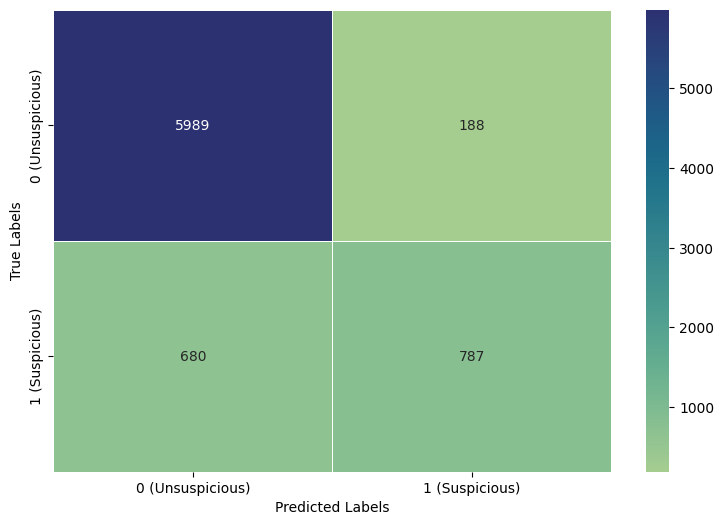

In [ ]:
# plot and store confusion matrix
df_cm=pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize=(9, 6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='crest', linewidth=.5) # annot: if True, write the data value in each cell
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("confusion_matrix.png")

## Draw accuracy and loss

In [ ]:
def show_accuracy_history(train_acc_history, valid_acc_history, test_acc_history):
    plt.plot(train_acc_history)
    plt.plot(valid_acc_history)
    plt.plot(test_acc_history)
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid', 'test'], loc='upper left')
    plt.show()

def show_loss_history(loss_history):
    plt.plot(loss_history)
    plt.title('Train History')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

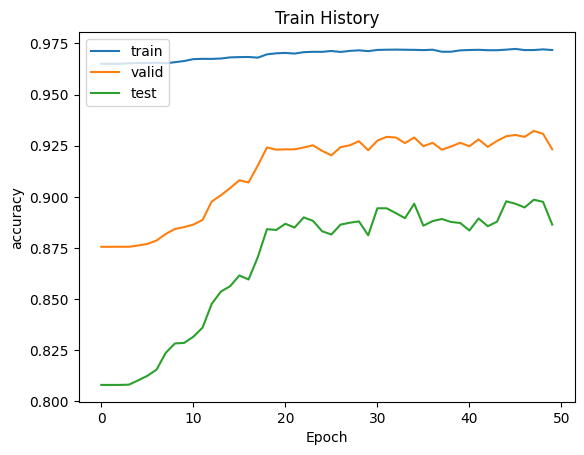

In [ ]:
show_accuracy_history(train_acc_history, valid_acc_history, test_acc_history)

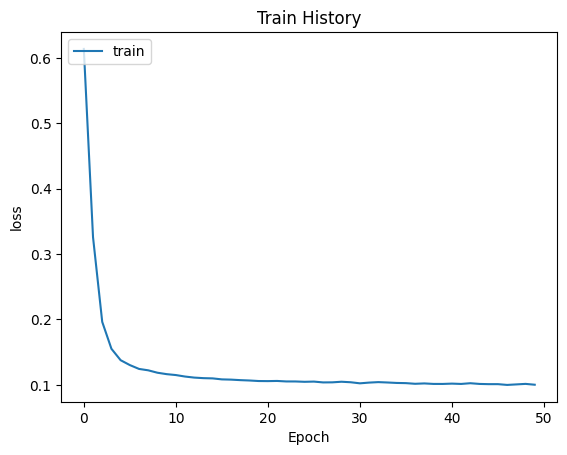

In [ ]:
show_loss_history(loss_history)

## Draw ROC curve

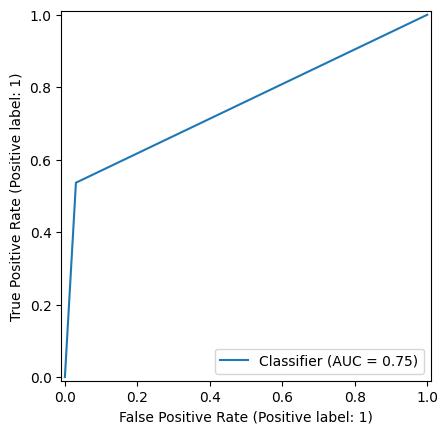

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(true, pred)
plt.show()